In [228]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

In [230]:
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=lambda img, target: (F.to_tensor(img), remove_invalid_boxes(target))
    )


In [231]:
# Dataset class
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()
    )

# Load datasets
train_dataset = get_coco_dataset(
    img_dir="Obj_detect/train",
    ann_file="Obj_detect/train_annotations/UnstableDetection_Annotations_coco.json"
)

val_dataset = get_coco_dataset(
    img_dir="Obj_detect/val",
    ann_file="Obj_detect/val_annotations/obj_val_coco.json"
)



# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))



loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [234]:
# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [235]:
# Initialize the model
num_classes = 3 # Stable, Unstable
model = get_model(num_classes)

In [238]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Using device: cuda


In [239]:
for img, target in train_loader:
    print("Target structure:", target)  # Debugging step
    break


Target structure: ([{'segmentation': [[184, 340, 272, 340, 272, 393, 184, 393]], 'area': 4664, 'bbox': [184, 340, 88, 53], 'iscrowd': 0, 'id': 1, 'image_id': 1, 'category_id': 1}, {'segmentation': [[172, 230, 261, 230, 261, 278, 172, 278]], 'area': 4272, 'bbox': [172, 230, 89, 48], 'iscrowd': 0, 'id': 2, 'image_id': 1, 'category_id': 1}, {'segmentation': [[111, 87, 284, 87, 284, 173, 111, 173]], 'area': 14878, 'bbox': [111, 87, 173, 86], 'iscrowd': 0, 'id': 3, 'image_id': 1, 'category_id': 2}], [{'segmentation': [[283, 136, 475, 136, 475, 278, 283, 278]], 'area': 27264, 'bbox': [283, 136, 192, 142], 'iscrowd': 0, 'id': 4, 'image_id': 2, 'category_id': 2}], [{'segmentation': [[136, 230, 226, 230, 226, 319, 136, 319]], 'area': 8010, 'bbox': [136, 230, 90, 89], 'iscrowd': 0, 'id': 5, 'image_id': 3, 'category_id': 1}, {'segmentation': [[82, 104, 246, 104, 246, 191, 82, 191]], 'area': 14268, 'bbox': [82, 104, 164, 87], 'iscrowd': 0, 'id': 6, 'image_id': 3, 'category_id': 2}], [{'segmentatio

In [240]:
for img, target in train_loader:
    # Print the first image and target
    print("First image shape:", img[0].shape)  # Print shape of the first image in the batch
    print("First target:", target[0])  # Print the first target in the batch
    # Check the bounding boxes
    for bbox_dict in target[0]:  # Iterate through each target (dictionary)
        bbox = bbox_dict['bbox']  # Extract the bounding box
        x_min, y_min, x_max, y_max = bbox  # Unpack the bounding box values
        if x_max <= x_min or y_max <= y_min:
                print(f"Invalid box at index {i} in target: {bbox}")
                print(f"Image index: {i}")
    
        # Assert to ensure the bbox is valid
        assert width > 0, f"Invalid width in bbox {bbox}"
        assert height > 0, f"Invalid height in bbox {bbox}"
        
    break  # Only check the first batch


First image shape: torch.Size([3, 512, 512])
First target: [{'segmentation': [[184, 340, 272, 340, 272, 393, 184, 393]], 'area': 4664, 'bbox': [184, 340, 88, 53], 'iscrowd': 0, 'id': 1, 'image_id': 1, 'category_id': 1}, {'segmentation': [[172, 230, 261, 230, 261, 278, 172, 278]], 'area': 4272, 'bbox': [172, 230, 89, 48], 'iscrowd': 0, 'id': 2, 'image_id': 1, 'category_id': 1}, {'segmentation': [[111, 87, 284, 87, 284, 173, 111, 173]], 'area': 14878, 'bbox': [111, 87, 173, 86], 'iscrowd': 0, 'id': 3, 'image_id': 1, 'category_id': 2}]
Invalid box at index 0 in target: [184, 340, 88, 53]
Image index: 0
Invalid box at index 0 in target: [172, 230, 89, 48]
Image index: 0
Invalid box at index 0 in target: [111, 87, 173, 86]
Image index: 0


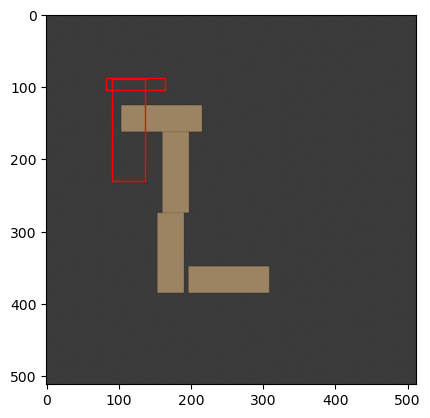

In [249]:
# Visualize the image and its boxes for further inspection
image, target = train_loader.dataset[2]  # Access the first element
image = image.permute(1, 2, 0)  # Convert from Tensor to HxWxC format for displaying

plt.imshow(image)
for img, target in train_loader:
    for bbox_dict in target[2]:  # Iterate through each target (dictionary)
        bbox = bbox_dict['bbox']  # Extract the bounding box
        x_min, y_min, x_max, y_max = bbox  # Unpack the bounding box values
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          linewidth=1, edgecolor='r', facecolor='none'))
    break
plt.show()


In [251]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    for images, targets in data_loader:
        # Move images to the device
        images = [img.to(device) for img in images]

        # Validate and process targets
        processed_targets = []
        valid_images = []
        for i, target in enumerate(targets):
            boxes = []
            labels = []
            for obj in target:
                # Extract bbox
                bbox = obj["bbox"]  # Format: [x, y, width, height]
                x, y, w, h = bbox

                # Ensure the width and height are positive
                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])  # Convert to [x_min, y_min, x_max, y_max]
                    labels.append(obj["category_id"])

            # Only process if there are valid boxes
            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append(processed_target)
                valid_images.append(images[i])  # Add only valid images

        # Skip iteration if no valid targets
        if not processed_targets:
            continue

        # Ensure images and targets are aligned
        images = valid_images

        # Forward pass
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch}] Loss: {losses.item():.4f}")

In [253]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()
    
    # Save the model's state dictionary after every epoch
    model_path = f"fasterrcnn_resnet50_epoch_{epoch + 1}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved: {model_path}")

Epoch [0] Loss: 0.4347
Model saved: fasterrcnn_resnet50_epoch_1.pth
Epoch [1] Loss: 0.3516
Model saved: fasterrcnn_resnet50_epoch_2.pth
Epoch [2] Loss: 0.3010
Model saved: fasterrcnn_resnet50_epoch_3.pth
Epoch [3] Loss: 0.2391
Model saved: fasterrcnn_resnet50_epoch_4.pth
Epoch [4] Loss: 0.2584
Model saved: fasterrcnn_resnet50_epoch_5.pth
Epoch [5] Loss: 0.2452
Model saved: fasterrcnn_resnet50_epoch_6.pth
Epoch [6] Loss: 0.2497
Model saved: fasterrcnn_resnet50_epoch_7.pth
Epoch [7] Loss: 0.2337
Model saved: fasterrcnn_resnet50_epoch_8.pth
Epoch [8] Loss: 0.2472
Model saved: fasterrcnn_resnet50_epoch_9.pth
Epoch [9] Loss: 0.2350
Model saved: fasterrcnn_resnet50_epoch_10.pth


C:\Users\ajeet\AppData\Local\Temp\ipykernel_40376\1155764989.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("obj_models/fasterrcnn_res

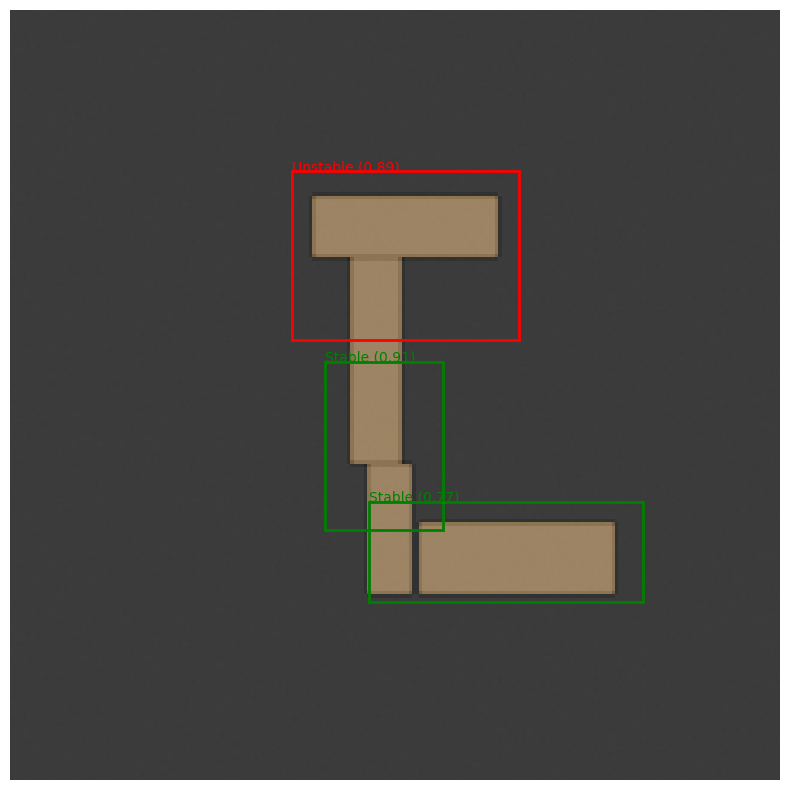

In [268]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


# Initialize the model
num_classes = 3  # Background + Stable, Unstable

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


# Load the trained model
model = get_model(num_classes)
model.load_state_dict(torch.load("obj_models/fasterrcnn_resnet50_epoch_9.pth"))
model.to(device)
model.eval()  # Set the model to evaluation mode


def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open image
    image_tensor = F.to_tensor(image).unsqueeze(0)  # Convert image to tensor and add batch dimension
    return image_tensor.to(device)



# Load the unseen image
#image_path = "Obj_detect/test/render_11.png"
image_path = "4B-2D-Non/test/Unstable/render_132.png"
image_tensor = prepare_image(image_path)

with torch.no_grad():  # Disable gradient computation for inference
    prediction = model(image_tensor)

# `prediction` contains:
# - boxes: predicted bounding boxes
# - labels: predicted class labels
# - scores: predicted scores for each box (confidence level)
COCO_CLASSES = {0: "Background", 1: "Stable", 2: "Unstable"}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")


class_colors = {1: 'green', 2: 'red'}  # Stable: Green, Unstable: Red    
# Draw bounding boxes with the correct class names and increase image size
def draw_boxes(image, prediction, fig_size=(10, 10)):
    boxes = prediction[0]['boxes'].cpu().numpy()  # Get predicted bounding boxes
    labels = prediction[0]['labels'].cpu().numpy()  # Get predicted labels
    scores = prediction[0]['scores'].cpu().numpy()  # Get predicted scores
    
    # Set a threshold for showing boxes (e.g., score > 0.5)
    threshold = 0.65
    
    # Set up the figure size to control the image size
    plt.figure(figsize=fig_size)  # Adjust the figure size here

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)  # Get the class name
            color = class_colors.get(label, 'blue')  # Default to blue if unknown
            
            plt.imshow(image)  # Display the image
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                              linewidth=2, edgecolor=color, facecolor='none'))
            plt.text(x_min, y_min, f"{class_name} ({score:.2f})", color=color)
    
    plt.axis('off')  # Turn off axis
    plt.show()

# Display the image with bounding boxes and correct labels
draw_boxes(Image.open(image_path), prediction, fig_size=(12, 10))  # Example of increased size